# CS146 Final Project
## Modeling and forecasting atmospheric CO₂ from 1958 until 2058

Available as a gist [here](https://gist.github.com/viniciusmss/a92c2a8516fb31d832ae56298dd876db).

In [1]:
# Loading packages
import pandas as pd
import numpy as np
import scipy.stats as sts
import pystan
from IPython.display import display
import matplotlib.pyplot as plt

### Data Preprocessing

In [2]:
# Loading data
data = pd.read_csv(
    "http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv", 
    skiprows=44, names=["Date", "ppm"])

# Convering date column to datetime object
data["Date"] = pd.to_datetime(data["Date"])

print("There are {:d} data points.".format(len(data)))
display(data.head())

There are 3091 data points.


,Date,ppm
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


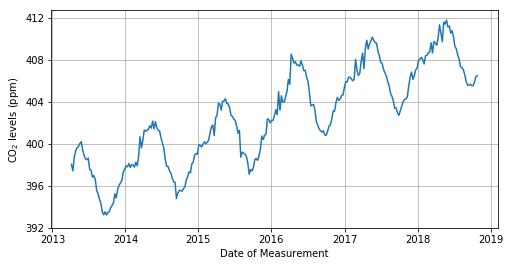

In [3]:
# Reproducing Figure 1
# Visualizing data in recent years

fig1 = plt.figure(figsize=(8,4))
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["ppm"]])
plt.grid()
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.yticks(np.linspace(392, 412, 6))
plt.show()
fig1.savefig("Figure1.png")

In [4]:
# Converting Dates to # of years passed since measurements started
data["Years"] = ((pd.to_datetime(data.Date) - pd.to_datetime(data.Date[0])).dt.days) / 365.25

# The exponential model converges when receiving data this way
data["Time"] = data["Years"] / max(data["Years"])

display(data.tail())

,Date,ppm,Years,Time
3086,2018-09-29,405.56,60.503765,0.998735
3087,2018-10-06,405.56,60.522930,0.999051
3088,2018-10-13,405.91,60.542094,0.999367
3089,2018-10-20,406.42,60.561259,0.999684
3090,2018-10-27,406.51,60.580424,1.000000


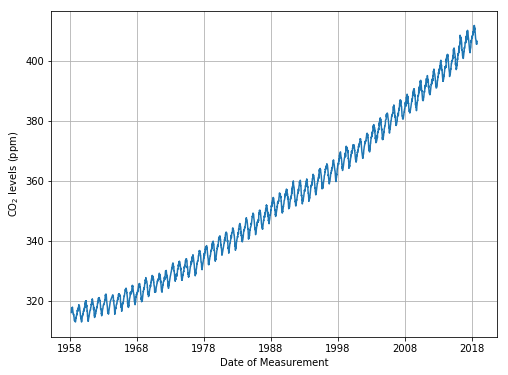

In [5]:
# Reproducing Figure 2
# Visualizing data across the whole time period

fig2 = plt.figure(figsize=(8,6))
plt.plot(data.Date, data.ppm)
plt.grid()
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()
fig2.savefig("Figure2.png")

In [6]:
stan_data_Years = {
    "n_data" : len(data),
    "time" : data.Years.values,
    "ppms" : data.ppm.values
}

stan_data_Time = {
    "n_data" : len(data),
    "time" : data.Time.values,
    "ppms" : data.ppm.values
}

### Modeling: Trend

In [7]:
linear_trend_code = """
data {
    int<lower=0> n_data;             // number of data
    real<lower=0> time[n_data];      // time elapsed since start of measurement
    real<lower=0> ppms[n_data];      // measured ppm
}

parameters {
    real<lower=0> a;                
    real<lower=0> b;
    real<lower=0> noise;
}

model {
 
    // Priors
    a ~ normal(300, 20);
    b ~ normal(1, 2);
    noise ~ normal(10, 2);
    
    for (i in 1:n_data) {
        ppms[i] ~ normal(a + b*time[i], noise); 
    }
}

"""

quadratic_trend_code = """
data {
    int<lower=0> n_data;             // number of data
    real<lower=0> time[n_data];      // days since start of measurement
    real<lower=0> ppms[n_data];      // measured ppm
}

parameters {
    real<lower=0> a;                
    real b;
    real c;
    real<lower=0> noise;
}

model {
 
    // Priors
    a ~ normal(300, 20);
    b ~ normal(0, 10);
    c ~ normal(0, 2);
    noise ~ normal(10, 2);
    
    for (i in 1:n_data) {
        ppms[i] ~ normal(a + b*time[i] + c*(time[i]^2), noise); 
    }
}

"""

exp_trend_code = """
data {
    int<lower=0> n_data;             // number of data
    real<lower=0> time[n_data];       // days since start of measurement
    real<lower=0> ppms[n_data];      // measured ppm
}

parameters {
    real<lower=0> a;                
    real<lower=0> b;
    real<lower=0> noise;
}

model {
 
    // Priors
    a ~ normal(300, 20);
    b ~ normal(1, 1);
    noise ~ normal(5, 2);
    for (i in 1:n_data) {
        ppms[i] ~ normal(a*exp(b*time[i]), noise); 
    }
}

"""

linear_model = pystan.StanModel(model_code=linear_trend_code)
quadratic_model = pystan.StanModel(model_code=quadratic_trend_code)
exp_model = pystan.StanModel(model_code=exp_trend_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_57499e7daf7de7ac0aa7053e0a749412 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b48542d65c587224a3c87cbc2b6f16e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd6597d450aff54c541d7c5f561a4fc5 NOW.


#### linear

In [8]:
linear_results = linear_model.sampling(data=stan_data_Years, iter=2000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 10, 'adapt_delta' : 0.999},
                              refresh = 50)
print(linear_results)

Inference for Stan model: anon_model_57499e7daf7de7ac0aa7053e0a749412.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     306.37  4.2e-3   0.15  306.1 306.27 306.37 306.48 306.66   1238    1.0
b       1.56  1.3e-4 4.2e-3   1.55   1.56   1.56   1.56   1.57   1021    1.0
noise   4.13  1.5e-3   0.05   4.03    4.1   4.13   4.17   4.24   1346    1.0
lp__   -5925    0.03   1.18  -5928  -5926  -5925  -5924  -5924   1304    1.0

Samples were drawn using NUTS at Tue Dec  4 11:47:37 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [8]:
quadratic_results = quadratic_model.sampling(data=stan_data_Years, iter=2000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 14, 'adapt_delta' : 0.999},
                              refresh = 10)
print(quadratic_results)

Inference for Stan model: anon_model_3b48542d65c587224a3c87cbc2b6f16e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     314.49  4.5e-3   0.12 314.25  314.4 314.49 314.57 314.73    765    1.0
b       0.78  3.6e-4 9.3e-3   0.76   0.77   0.78   0.78    0.8    644    1.0
c       0.01  5.6e-6 1.5e-4   0.01   0.01   0.01   0.01   0.01    685    1.0
noise   2.24  8.5e-4   0.03   2.19   2.22   2.24   2.26    2.3   1231    1.0
lp__   -4043    0.05   1.48  -4047  -4044  -4043  -4042  -4042    842    1.0

Samples were drawn using NUTS at Fri Dec  7 13:30:44 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [10]:
exp_results = exp_model.sampling(data=stan_data_Time, iter=2000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 10, 'adapt_delta' : 0.999},
                              refresh = 50)
print(exp_results)

Inference for Stan model: anon_model_bd6597d450aff54c541d7c5f561a4fc5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      308.2  3.0e-3   0.11 307.97 308.12  308.2 308.27 308.42   1404    1.0
b       0.27  1.7e-5 6.0e-4   0.27   0.27   0.27   0.27   0.27   1228    1.0
noise   3.38  1.3e-3   0.04    3.3   3.35   3.38   3.41   3.46   1111    1.0
lp__   -5305    0.03   1.17  -5308  -5306  -5305  -5304  -5304   1163    1.0

Samples were drawn using NUTS at Tue Dec  4 11:58:23 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [9]:
# Reproducing Figure 3

#linear_samples = linear_results.extract()
quadratic_samples = quadratic_results.extract()
#exp_samples = exp_results.extract()

#linear_approx = linear_samples['a'].mean() + linear_samples['b'].mean()*data.Years.values
quadratic_approx = quadratic_samples['a'].mean() +\
                   quadratic_samples['b'].mean()*data.Years.values +\
                   quadratic_samples['c'].mean()*data.Years.values**2
#exp_approx = exp_samples['a'].mean()*np.exp(exp_samples['b'].mean()*data.Time.values)

# fig3 = plt.figure(figsize=(18,5))
# plt.subplot(1, 3, 1)
# plt.plot(data.Date, data.ppm, alpha=0.5)
# plt.plot(data.Date, linear_approx, color="red")
# plt.title("Linear Trend Model")
# plt.xlabel("Date of Measurement")
# plt.ylabel(r'CO$_2$ levels (ppm)')
# plt.subplot(1, 3, 2)
# plt.plot(data.Date, data.ppm, alpha=0.5)
# plt.plot(data.Date, quadratic_approx, color="red")
# plt.title("Quadratic Trend Model")
# plt.xlabel("Date of Measurement")
# plt.ylabel(r'CO$_2$ levels (ppm)')
# plt.subplot(1, 3, 3)
# plt.plot(data.Date, data.ppm, alpha=0.5)
# plt.plot(data.Date, exp_approx, color="red")
# plt.title("Exponential Trend Model")
# plt.xlabel("Date of Measurement")
# plt.ylabel(r'CO$_2$ levels (ppm)')
# plt.show()
# fig3.savefig("Figure3.png")

In [10]:
# Reproducing Figure 4

#residuals_linear = data.ppm - linear_approx
residuals_quadratic = data.ppm - quadratic_approx
#residuals_exp = data.ppm - exp_approx

#linear_RMSE = np.sqrt(np.mean(residuals_linear**2))
quadratic_RMSE = np.sqrt(np.mean(residuals_quadratic**2))
#exp_RMSE = np.sqrt(np.mean(residuals_exp**2))

# fig4 = plt.figure(figsize=(18,4))
# plt.subplot(1, 3, 1)
# plt.plot(data.Date, residuals_linear, alpha = 0.8, color="grey")
# plt.title("Linear Trend Residuals - RMSE = {:.3f}".format(linear_RMSE))
# plt.xlabel("Date of Measurement")
# plt.ylabel(r'CO$_2$ levels (ppm)')
# plt.subplot(1, 3, 2)
# plt.plot(data.Date, residuals_quadratic, alpha = 0.8, color="grey")
# plt.title("Quadratic Trend Residuals - RMSE = {:.3f}".format(quadratic_RMSE))
# plt.xlabel("Date of Measurement")
# plt.ylabel(r'CO$_2$ levels (ppm)')
# plt.subplot(1, 3, 3)
# plt.plot(data.Date, residuals_exp, alpha = 0.8, color="grey")
# plt.title("Exponential Trend Residuals - RMSE = {:.3f}".format(exp_RMSE))
# plt.xlabel("Date of Measurement")
# plt.ylabel(r'CO$_2$ levels (ppm)')
# plt.show()
# fig4.savefig("Figure4.png")

### Modeling: Seasonality

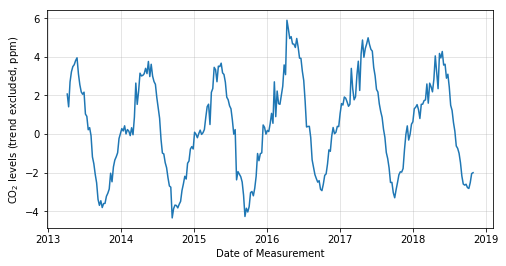

In [12]:
# Reproducing Figure 5

data["untrended_ppm"] = residuals_quadratic

fig5 = plt.figure(figsize=(8,4))
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["untrended_ppm"]])
plt.grid(alpha=0.4)
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (trend excluded, ppm)')
plt.show()
fig5.savefig("Figure5.png")

In [13]:
stan_data_Years = {
    "n_data" : len(data),
    "day" : data.Years.values,
    "ppms" : data.untrended_ppm.values,
    "period" : 2*np.pi
}

In [ ]:
new_code = """
data {
    int<lower=0> n_data;             // number of data
    real<lower=0> day[n_data];       // days since start of measurement
    real ppms[n_data];      // measured ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> a;                
    real<lower=0> b;
    unit_vector[2] phase_helper1;
    real<lower=0> noise;
    real<lower=0, upper=1> theta;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
 
    // Priors
    a ~ normal(0, 4);
    b ~ normal(0, 4);
    noise ~ inv_gamma(3, 2);
    theta ~ uniform(0, 1);

    for (i in 1:n_data) {
        int aux;
        aux ~ bernoulli(theta);
        ppms[i] ~ normal(a*sin(period*day[i] + phase1) + b*sin(period*2*day[i] + phase1 + aux*pi()), noise); 
    }
}

"""

new_model = pystan.StanModel(model_code=new_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3c0232d36fb25a1cbc0386e4d6d5635b NOW.


In [ ]:
sine_results = sine_model.sampling(data=stan_data_Years, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 12, 'adapt_delta' : 0.9999},
                              refresh = 10)
print(sine_results)

In [15]:
sine_code = """
data {
    int<lower=0> n_data;             // number of data
    real<lower=0> day[n_data];       // days since start of measurement
    real ppms[n_data];      // measured ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> a;
    unit_vector[2] phase_helper1;
    real<lower=0> noise;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
 
    // Priors
    a ~ normal(4, 2);
    noise ~ inv_gamma(3, 2);

    for (i in 1:n_data) {
        ppms[i] ~ normal(a*sin(period*day[i] + phase1), noise); 
    }
}

"""

cos_code = """
data {
    int<lower=0> n_data;             // number of data
    real<lower=0> day[n_data];       // days since start of measurement
    real ppms[n_data];      // measured ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> a;
    unit_vector[2] phase_helper1;
    real<lower=0> noise;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
 
    // Priors
    a ~ normal(4, 2);
    noise ~ inv_gamma(3, 2);

    for (i in 1:n_data) {
        ppms[i] ~ normal(a*cos(period*day[i] + phase1), noise); 
    }
}

"""

double_positive_sine_code = """
data {
    int<lower=0> n_data;             // number of data
    real<lower=0> day[n_data];       // days since start of measurement
    real ppms[n_data];      // measured ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> a;                
    real<lower=0> b;
    unit_vector[2] phase_helper1;
    real<lower=0> noise;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
 
    // Priors
    a ~ normal(0, 4);
    b ~ normal(0, 4);
    noise ~ inv_gamma(3, 2);

    for (i in 1:n_data) {
        ppms[i] ~ normal(a*sin(period*day[i] + phase1) + b*sin(period*2*day[i] + phase1), noise); 
    }
}

"""

double_negative_sine_code = """
data {
    int<lower=0> n_data;             // number of data
    real<lower=0> day[n_data];       // days since start of measurement
    real ppms[n_data];      // measured ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> a;                
    real<upper=0> b;
    unit_vector[2] phase_helper1;
    real<lower=0> noise;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
 
    // Priors
    a ~ normal(0, 4);
    b ~ normal(0, 4);
    noise ~ inv_gamma(3, 2);

    for (i in 1:n_data) {
        ppms[i] ~ normal(a*sin(period*day[i] + phase1) + b*sin(period*2*day[i] + phase1), noise); 
    }
}

"""

sine_model = pystan.StanModel(model_code=sine_code)
cos_model = pystan.StanModel(model_code=cos_code)
double_positive_sine_model = pystan.StanModel(model_code=double_positive_sine_code)
double_negative_sine_model = pystan.StanModel(model_code=double_negative_sine_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5cf550446902d62497cf1b62573cb0e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_efae9aed17a33058d816696d2325e50c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_53c11d0ac1a6b7a72af1b7af25664eb4 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3db07dcf00d5a2ce2261c52118eada8e NOW.


In [16]:
sine_results = sine_model.sampling(data=stan_data_Years, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 12, 'adapt_delta' : 0.9999},
                              refresh = 10)
print(sine_results)

Inference for Stan model: anon_model_c5cf550446902d62497cf1b62573cb0e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a                  2.86  8.1e-4   0.02   2.81   2.84   2.86   2.87   2.91    875    1.0
phase_helper1[1]   0.91  8.3e-5 3.7e-3   0.91   0.91   0.91   0.92   0.92   2015    1.0
phase_helper1[2]   0.41  1.9e-4 8.4e-3   0.39    0.4   0.41   0.41   0.42   2017    1.0
noise              0.97  4.2e-4   0.01   0.95   0.96   0.97   0.98    1.0    922    1.0
phase1             1.15  2.0e-4 9.2e-3   1.14   1.15   1.15   1.16   1.17   2017    1.0
lp__              -1459    0.08   1.58  -1463  -1460  -1459  -1458  -1457    387    1.0

Samples were drawn using NUTS at Tue Dec  4 12:18:10 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (

In [17]:
cos_results = cos_model.sampling(data=stan_data_Years, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 14, 'adapt_delta' : 0.999},
                              refresh = 10)
print(cos_results)

Inference for Stan model: anon_model_efae9aed17a33058d816696d2325e50c.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a                  2.86  7.8e-4   0.02   2.81   2.84   2.86   2.88    2.9    953    1.0
phase_helper1[1]  -0.41  2.0e-4 8.1e-3  -0.42  -0.41  -0.41   -0.4  -0.39   1680    1.0
phase_helper1[2]   0.91  8.8e-5 3.6e-3   0.91   0.91   0.91   0.92   0.92   1679    1.0
noise              0.97  3.9e-4   0.01   0.95   0.96   0.97   0.98    1.0    942    1.0
phase1            -0.42  2.2e-4 8.9e-3  -0.43  -0.42  -0.42  -0.41   -0.4   1680    1.0
lp__              -1459    0.09   1.65  -1463  -1460  -1459  -1458  -1457    309   1.02

Samples were drawn using NUTS at Tue Dec  4 12:35:38 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (

In [18]:
double_positive_sine_results = double_positive_sine_model.sampling(data=stan_data_Years, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 14, 'adapt_delta' : 0.999},
                              refresh = 10)
print(double_positive_sine_results)

Inference for Stan model: anon_model_53c11d0ac1a6b7a72af1b7af25664eb4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a                  2.14    0.87   1.24 2.5e-4   1.25   2.85   2.87    2.9      2  60.88
b                   0.2    0.25   0.35 5.0e-5 5.6e-4 1.4e-3   0.36   0.88      2   12.9
phase_helper1[1]   0.47    0.55   0.77  -0.91  -0.01   0.91   0.92   0.92      2  49.41
phase_helper1[2]   0.42    0.02   0.05   0.39    0.4   0.41   0.42   0.56      3   1.55
noise              1.27    0.37   0.52   0.95   0.97   0.98   1.61   2.21      2  31.01
phase1              0.6    0.68   0.96  -1.15   0.03   1.15   1.16   1.17      2  29.57
lp__              -2088  759.92 1075.2  -3952  -2836  -1468  -1466  -1465      2 612.19

Samples were drawn using NUTS at Tue Dec  4 13:07:53 2018.
For each parameter, n_eff is a crude measure of e

In [27]:
double_negative_sine_results = double_negative_sine_model.sampling(data=stan_data_Years, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 14, 'adapt_delta' : 0.999},
                              refresh = 10)
print(double_negative_sine_results)

Inference for Stan model: anon_model_3db07dcf00d5a2ce2261c52118eada8e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a                  2.86  5.9e-4   0.02   2.81   2.84   2.86   2.87    2.9   1521    1.0
b                 -0.51  6.5e-4   0.02  -0.56  -0.53  -0.51   -0.5  -0.47   1299    1.0
phase_helper1[1]   0.93  7.4e-5 3.1e-3   0.92   0.93   0.93   0.93   0.94   1734    1.0
phase_helper1[2]   0.37  1.9e-4 7.7e-3   0.35   0.36   0.37   0.37   0.38   1732    1.0
noise               0.9  3.5e-4   0.01   0.88    0.9    0.9   0.91   0.93   1093    1.0
phase1             1.19  2.0e-4 8.3e-3   1.18   1.19   1.19    1.2   1.21   1732    1.0
lp__              -1239    0.07   1.68  -1243  -1240  -1238  -1237  -1236    620    1.0

Samples were drawn using NUTS at Tue Dec  4 14:09:13 2018.
For each parameter, n_eff is a crude measure of e

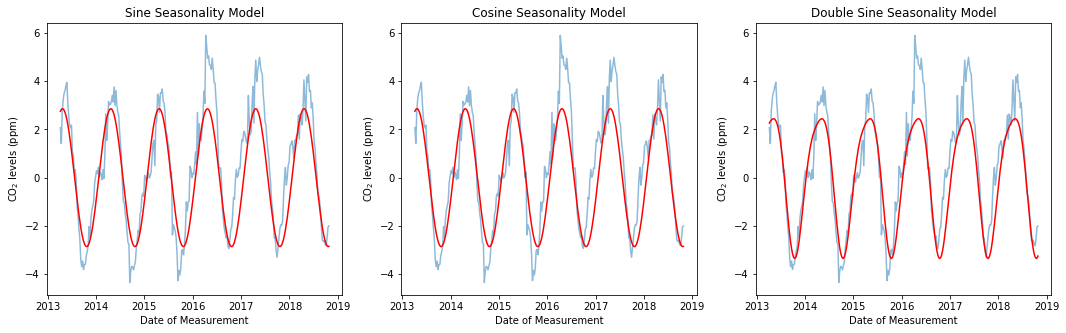

In [20]:
# Reproducing Figure 6

sine_samples = sine_results.extract()
cos_samples = cos_results.extract()
double_negative_sine_samples = double_negative_sine_results.extract()

sine_approx = sine_samples['a'].mean() * np.sin(2*np.pi*data.Years.values + sine_samples['phase1'].mean())
cos_approx = cos_samples['a'].mean() * np.cos(2*np.pi*data.Years.values + cos_samples['phase1'].mean())
double_negative_sine_approx = double_negative_sine_samples['a'].mean()*np.sin(
                                 2*np.pi*data.Years.values + double_negative_sine_samples['phase1'].mean()) + \
                              double_negative_sine_samples['b'].mean()*np.sin(
                                 4*np.pi*data.Years.values + double_negative_sine_samples['phase1'].mean())


fig6 = plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["untrended_ppm"]], alpha=0.5)
plt.plot(data.loc[2800:, ["Date"]], sine_approx[2800:], color="red")
plt.title("Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 2)
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["untrended_ppm"]], alpha=0.5)
plt.plot(data.loc[2800:, ["Date"]], cos_approx[2800:], color="red")
plt.title("Cosine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 3)
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["untrended_ppm"]], alpha=0.5)
plt.plot(data.loc[2800:, ["Date"]], double_negative_sine_approx[2800:], color="red")
plt.title("Double Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()
fig6.savefig("Figure6.png")

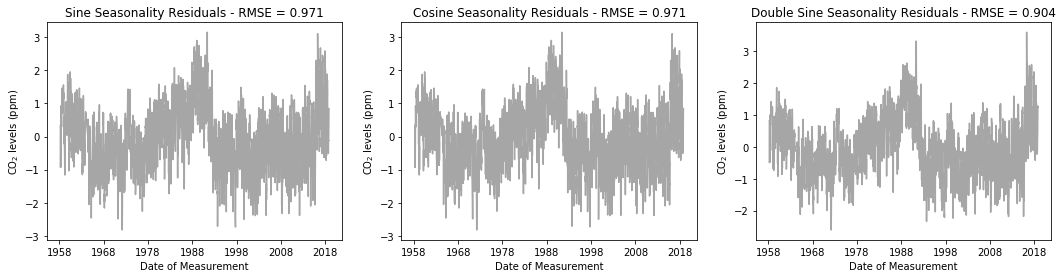

In [28]:
# Reproducing Figure 7

residuals_sine = data.untrended_ppm - sine_approx
residuals_cos = data.untrended_ppm - cos_approx
residuals_double_sine = data.untrended_ppm - double_negative_sine_approx

sine_RMSE = np.sqrt(np.mean(residuals_sine**2))
cos_RMSE = np.sqrt(np.mean(residuals_cos**2))
double_sine_RMSE = np.sqrt(np.mean(residuals_double_sine**2))

fig7 = plt.figure(figsize=(18,4))
plt.subplot(1, 3, 1)
plt.plot(data.Date, residuals_sine, alpha = 0.7, color="grey")
plt.title("Sine Seasonality Residuals - RMSE = {:.3f}".format(sine_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 2)
plt.plot(data.Date, residuals_cos, alpha = 0.7, color="grey")
plt.title("Cosine Seasonality Residuals - RMSE = {:.3f}".format(cos_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 3)
plt.plot(data.Date, residuals_double_sine, alpha = 0.7, color="grey")
plt.title("Double Sine Seasonality Residuals - RMSE = {:.3f}".format(double_sine_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()
fig7.savefig("Figure7.png")

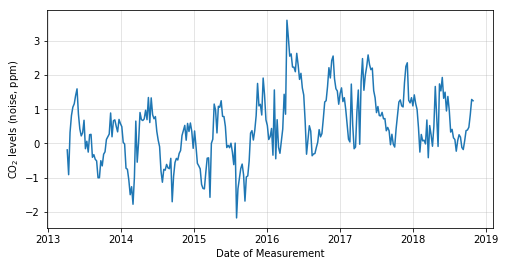

In [22]:
# Reproducing Figure 8

data["noise_ppm"] = residuals_double_sine

fig8 = plt.figure(figsize=(8,4))
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["noise_ppm"]])
plt.grid(alpha=0.4)
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (noise, ppm)')
plt.show()
fig8.savefig("Figure8.png")

In [29]:
# Retrieving the posterior samples of the coefficients
trend_coef_samples = np.array(list(map(list, zip(*quadratic_samples.values()))))[:2000, :3]
season_coefs_samples = list(map(list, zip(*double_negative_sine_samples.values())))

# Ignoring the posterior samples of the phase helpers
season_coefs_samples = np.array([sample[:2] + sample[3:5] for sample in season_coefs_samples])

In [30]:
# likelihood / posterior predictive function
def likelihood(time, trend_coefs, season_coefs):
    c0, c1, c2 = trend_coefs
    c3, c5, noise, phase = season_coefs
    return(np.array(sts.norm.rvs(c0 + c1*time + c2*time**2 + \
                                 c3*np.sin(2*np.pi*time + phase) + \
                                 c5*np.sin(4*np.pi*time + phase), noise))) 

### Inference

In [39]:
# Dates for which we want to generate predictions
prediction_dates = pd.date_range("2019-01-01", "2058-03-29", freq='W-FRI')
prediction_times = (prediction_dates - pd.to_datetime(data.Date[0])).days / 365.25

# Generate predictions
y_pred = np.array([likelihood(prediction_times, trend_coefs, season_coefs) \
                   for trend_coefs, season_coefs in zip(trend_coef_samples, season_coefs_samples)])

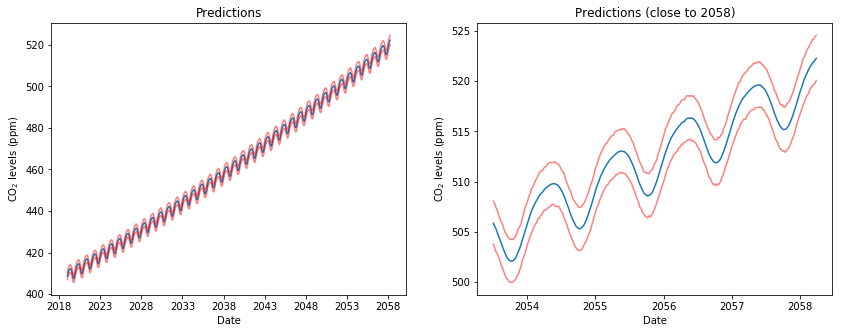

In [82]:
# Mean and CI of the predictions
mean_pred = y_pred.mean(axis=0)
CI_lower = np.percentile(y_pred, axis=0, q=2.5)
CI_upper = np.percentile(y_pred, axis=0, q=97.5)

fig10 = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Predictions")
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.plot(prediction_dates, mean_pred)
plt.plot(prediction_dates, CI_lower, color="red", alpha=0.5)
plt.plot(prediction_dates, CI_upper, color="red", alpha=0.5)

plt.subplot(1,2,2)
plt.title("Predictions (close to 2058)")
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.plot(prediction_dates[1800:], mean_pred[1800:])
plt.plot(prediction_dates[1800:], CI_lower[1800:], color="red", alpha=0.5)
plt.plot(prediction_dates[1800:], CI_upper[1800:], color="red", alpha=0.5)
plt.show()
fig10.savefig("Figure10.png")

In [42]:
data_pred = pd.DataFrame({"Date":prediction_dates, 
                          "2.5%":CI_lower, 
                          "Mean":mean_pred, 
                          "97.5":CI_upper})

In [64]:
print('The predicted atmospheric carbon dioxide level in {:{dfmt}} is of {:.0f} ppm.'.format(
    data_pred.iloc[-1,2],data_pred.iloc[-1,3], dfmt='%Y-%m-%d'))

print('The 95% confidence interval is [{:.1f}, {:.1f}].'.format(
    data_pred.iloc[-1,0],data_pred.iloc[-1,1]))

The predicted atmospheric carbon dioxide level in 2058-03-29 is of 522 ppm.
The 95% confidence interval is [520.1, 524.6].


In [67]:
print("The threshold of 450 ppm will be surpassed with high confidence in {:{dfmt}}.".format(
    prediction_dates[np.min(np.argwhere(CI_lower > 450))], dfmt='%Y-%m-%d'))

The threshold of 450 ppm will be surpassed with high confidence in 2035-03-09.


### Posterior Predictive Checks

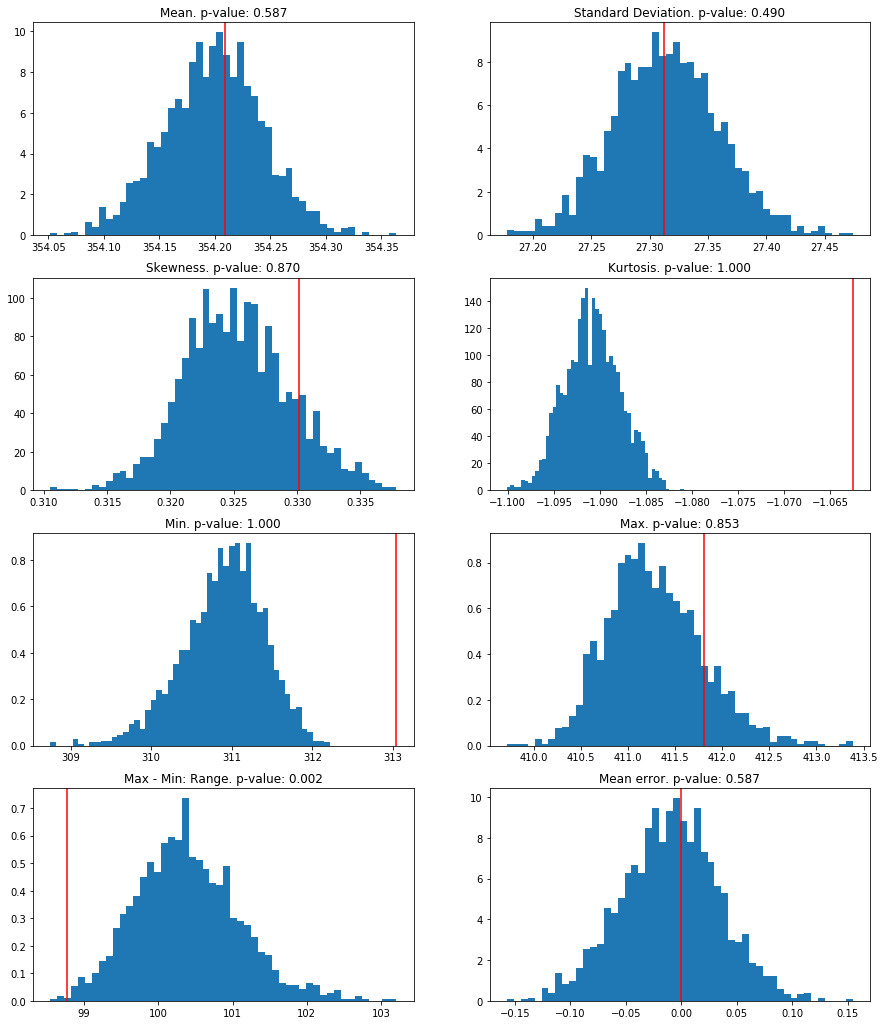

In [83]:
# Generating y_reps
y_reps = np.array([likelihood(data.Years.values, trend_coefs, season_coefs) \
                   for trend_coefs, season_coefs in zip(trend_coef_samples, season_coefs_samples)])

# Auxiliary plot function
def make_histogram(name, generated, expected_value, subplot_tuple):
    plt.subplot(*subplot_tuple)
    plt.hist(generated, bins=50, density=True)
    plt.title(name)
    # Draw red vertical line at the expected value of the test statistic.
    if expected_value is not None:
        plt.axvline(expected_value, color='red')

fig11 = plt.figure(figsize=(15,18))

# The test statistic for the generated data.
generated = np.mean(y_reps, axis=1)
# The measurement error is a normal distribution with 0 mean.
expected_value = np.mean(data.ppm.values)
# The name of the test statistic.
name = 'Mean. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 1))


generated = np.std(y_reps, axis=1)
expected_value = np.std(data.ppm.values)
name = 'Standard Deviation. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 2))
           

generated = sts.skew(y_reps, axis=1)
expected_value = sts.skew(data.ppm.values)
name = 'Skewness. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 3))


generated = sts.kurtosis(y_reps, axis=1)
expected_value = sts.kurtosis(data.ppm.values)
name = 'Kurtosis. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 4))


generated = np.min(y_reps, axis=1)
expected_value = np.min(data.ppm.values)
name = 'Min. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 5))


generated = np.max(y_reps, axis=1)
expected_value = np.max(data.ppm.values)
name = 'Max. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 6))


generated = np.ptp(y_reps, axis=1)
expected_value = np.ptp(data.ppm.values)
name = 'Max - Min: Range. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 7))

generated = np.mean(y_reps - data.ppm.values, axis=1)
expected_value = 0
name = 'Mean error. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 8))

plt.show()
fig11.savefig("Figure11.png")